# Hands-On NLP — Class 2

<span style="color:magenta">Group members:</span>

* Name 1
* Name 2
* Name 3

## Outline

- Embeddings from scratch

- Classifications with embeddings

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from nltk.tokenize import word_tokenize
from sklearn import (
    decomposition,
    ensemble,
    linear_model,
    metrics,
    model_selection,
    multiclass,
    naive_bayes,
    neighbors,
    svm,
    tree,
)
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm

In [2]:
tqdm.pandas()

nltk.download("punkt")

print("sklearn", sklearn.__version__)   # 1.3.2

sns.set_style("darkgrid")
sns.set_context("notebook")

pd.set_option("display.precision", 2)

sklearn 1.6.1


[nltk_data] Downloading package punkt to /home/petko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
TEXT_P = Path("texts")

CORPORA = [
    "mythology",
    "woodworking",
    "robotics",
    "hsm",
    "health",
    "portuguese",
]

EPS = np.finfo(float).eps

## Getting the data

In [4]:
corpora = {}
stats = []

for corpus in tqdm(CORPORA):
    print(corpus)
    texts = []
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open() as f:
            texts.append(f.read())

    corpora[corpus] = "".join(texts)

    stats.append(
        {
            "corpus": corpus,
            "files_n": len(texts),
            "chars_n": len(corpora[corpus]),
        }
    )

df = pd.DataFrame.from_records(stats, index=["corpus"])
df["text"] = [corpora[corpus] for corpus in corpora]
df

  0%|          | 0/6 [00:00<?, ?it/s]

mythology
woodworking
robotics
hsm
health
portuguese


,files_n,chars_n,text
corpus,,,
mythology,1503,4968342,Q:\n\nWhy were the Greek Gods on Olympus?\n\nI...
woodworking,2860,7839486,Q:\n\nIs support on three sides of a long popl...
robotics,39674,110877047,Q:\n\nErrors compiling Rosjava code\n\nI am ha...
hsm,2887,9466140,Q:\n\nAnalysis vs Synthesis in Greek Mathemati...
health,3733,10214223,Q:\n\nCan Sour/Acidic Food reduce libido in me...
portuguese,2026,4827567,Q:\n\nTradução de “full volume”\n\nEm inglês t...


### Tokenizing

In [5]:
# If your machine is slow, pickeling allows to go faster next time.

tokens_fp = "data/tokens.pkl"
try:
    tokens = pd.read_pickle(tokens_fp)
except FileNotFoundError:
    tokens = df.text.progress_map(word_tokenize)
    tokens.to_pickle(tokens_fp)

In [6]:
df["tokens"] = tokens
df["tokens_n"] = df.tokens.map(len)
df["types_n"] = df.tokens.map(set).map(len)
df

,files_n,chars_n,text,tokens,tokens_n,types_n
corpus,,,,,,
mythology,1503,4968342,Q:\n\nWhy were the Greek Gods on Olympus?\n\nI...,"[Q, :, Why, were, the, Greek, Gods, on, Olympu...",998926,53030
woodworking,2860,7839486,Q:\n\nIs support on three sides of a long popl...,"[Q, :, Is, support, on, three, sides, of, a, l...",1620394,35469
robotics,39674,110877047,Q:\n\nErrors compiling Rosjava code\n\nI am ha...,"[Q, :, Errors, compiling, Rosjava, code, I, am...",20494962,502398
hsm,2887,9466140,Q:\n\nAnalysis vs Synthesis in Greek Mathemati...,"[Q, :, Analysis, vs, Synthesis, in, Greek, Mat...",1865024,74635
health,3733,10214223,Q:\n\nCan Sour/Acidic Food reduce libido in me...,"[Q, :, Can, Sour/Acidic, Food, reduce, libido,...",1915518,71817
portuguese,2026,4827567,Q:\n\nTradução de “full volume”\n\nEm inglês t...,"[Q, :, Tradução, de, “, full, volume, ”, Em, i...",992726,63863


## Vectorization

### 🚧 TODO: How to vectorize text?

- Try counting words in the stackoverflow corpus based on a given vocabulary

- Apply reduction techniques to reduce the dimensionality to 2 dimensions (e.g., PCA)

- Plot the 2D vectors

In [7]:
words = (
    "myth,wood,robot,history,science,mathematics,health,portuguese,o".split(",")
)
wc_df = pd.DataFrame(index=df.index)
for w in words:
    wc_df[w] = df['text'].str.lower().str.count(w)

In [8]:
wc_df

,myth,wood,robot,history,science,mathematics,health,portuguese,o
corpus,,,,,,,,,
mythology,3926,175,9,322,61,5,34,4,295126
woodworking,19,14546,5,22,21,1,59,0,509952
robotics,341,301,77883,354,132,81,80,7,6777638
hsm,94,104,11,1932,1935,2654,55,11,549149
health,82,47,4,278,483,14,3770,4,614373
portuguese,10,39,3,20,9,6,14,1362,377712


/tmp/ipykernel_663225/4233222821.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (wc_df['PCA1'][i], wc_df['PCA2'][i]), fontsize=8)


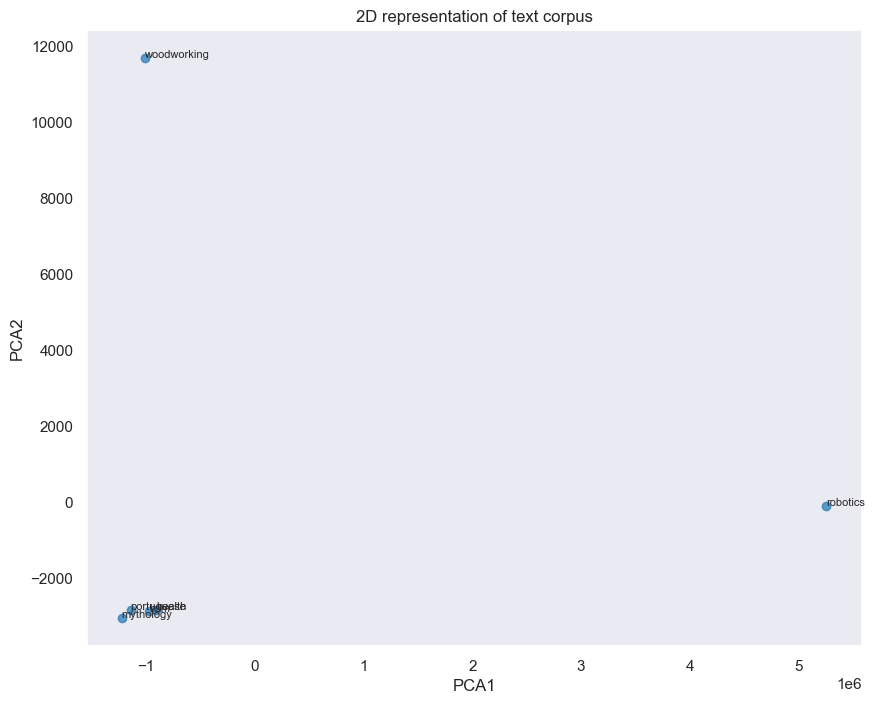

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(wc_df.values)

wc_df['PCA1'] = reduced_vectors[:, 0]
wc_df['PCA2'] = reduced_vectors[:, 1]

plt.figure(figsize=(10, 8))
plt.scatter(wc_df['PCA1'], wc_df['PCA2'], alpha=0.7)
for i, txt in enumerate(wc_df.index):
    plt.annotate(txt, (wc_df['PCA1'][i], wc_df['PCA2'][i]), fontsize=8)
plt.title("2D representation of text corpus")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.grid()
plt.show()

#### Bag of words

### 🚧 TODO: Implement another bag of words vectorizer model on the corpus

*   This time using [sklearn's `CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

*   Try first the provided example in the `CountVectorizer` documentation

    Try with and without the n-gram parameter

*   Then try to vectorize the stackoverflow corpus using `vocabulary=words`

#### First with a toy example

In [10]:
corpus = [
    "This is the first document.",
    "This document is the second document.",
    "And this is the third one.",
    "Is this the first document?",
]

With the whole vocabulary

In [11]:
vectorizer = CountVectorizer()

xs = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names_out())
print(xs.toarray())

vectorizer_2g = CountVectorizer(analyzer='word', ngram_range=(2, 2))
x2gs = vectorizer_2g.fit_transform(corpus)

print(vectorizer_2g.get_feature_names_out())

['and' 'document' 'first' 'is' 'one' 'second' 'the' 'third' 'this']
[[0 1 1 1 0 0 1 0 1]
 [0 2 0 1 0 1 1 0 1]
 [1 0 0 1 1 0 1 1 1]
 [0 1 1 1 0 0 1 0 1]]
['and this' 'document is' 'first document' 'is the' 'is this'
 'second document' 'the first' 'the second' 'the third' 'third one'
 'this document' 'this is' 'this the']


In [12]:
cv_df = pd.DataFrame(xs.toarray(), columns=vectorizer.get_feature_names_out())
cv_df.insert(0, "Document", corpus)
cv_df

,Document,and,document,first,is,one,second,the,third,this
0,This is the first document.,0,1,1,1,0,0,1,0,1
1,This document is the second document.,0,2,0,1,0,1,1,0,1
2,And this is the third one.,1,0,0,1,1,0,1,1,1
3,Is this the first document?,0,1,1,1,0,0,1,0,1


With a subset of the vocabulary

In [13]:
vocabulary = ["and", "document", "first"]
xs = vectorizer.fit_transform(vocabulary)
print(vectorizer.get_feature_names_out())
print(xs.toarray())

['and' 'document' 'first']
[[1 0 0]
 [0 1 0]
 [0 0 1]]


#### Reprocess the stackoverflow corpora with `CountVectorizer`

In [14]:
corpus = df['text'].tolist()

X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names_out())
print(X.toarray())

['00' '000' '0000' ... 'ｔｏｔａｌｌｙ' 'ｕｓｅ' 'ｙｏｕ']
[[   5   37    0 ...    0    0    0]
 [  23   51   29 ...    0    0    0]
 [3379 1544  843 ...    1    1    1]
 [  19  134   19 ...    0    0    0]
 [  57  436    1 ...    0    0    0]
 [  21  100    0 ...    0    0    0]]


### 🚧 TODO: Why is this different?

- Try to explain

- Give a simple example with the toy corpus below (with the same vocabulary)

In [32]:
test_text = (
    "myth wood robot history science mathematics health portuguese o "
    "myth wood robot history science mathematics health portuguese o".split(" ")
)

test_wc_df = pd.DataFrame(index=df.index)

for w in test_text:
    test_wc_df[w] = df['text'].str.lower().str.count(w)

test_wc_df

,myth,wood,robot,history,science,mathematics,health,portuguese,o
corpus,,,,,,,,,
mythology,3926,175,9,322,61,5,34,4,295126
woodworking,19,14546,5,22,21,1,59,0,509952
robotics,341,301,77883,354,132,81,80,7,6777638
hsm,94,104,11,1932,1935,2654,55,11,549149
health,82,47,4,278,483,14,3770,4,614373
portuguese,10,39,3,20,9,6,14,1362,377712


In [33]:
test_xs = vectorizer.fit_transform(test_text)

print(vectorizer.get_feature_names_out())
print(test_xs.toarray())

['health' 'history' 'mathematics' 'myth' 'portuguese' 'robot' 'science'
 'wood']
[[0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0]
 [0 0 1 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0]]


In [35]:
test_cv_df = pd.DataFrame(test_xs.toarray(), columns=vectorizer.get_feature_names_out())
test_cv_df.insert(0, "Document", test_text)
test_cv_df

,Document,health,history,mathematics,myth,portuguese,robot,science,wood
0,myth,0,0,0,1,0,0,0,0
1,wood,0,0,0,0,0,0,0,1
2,robot,0,0,0,0,0,1,0,0
3,history,0,1,0,0,0,0,0,0
4,science,0,0,0,0,0,0,1,0
5,mathematics,0,0,1,0,0,0,0,0
6,health,1,0,0,0,0,0,0,0
7,portuguese,0,0,0,0,1,0,0,0
8,o,0,0,0,0,0,0,0,0
9,myth,0,0,0,1,0,0,0,0


In the first case, CountVectorizer builds the vocabulary from the input corpus. In the second case, we explicitly provide a restricted vocabulary and this leads to different feature spaces and different dimensionality.


### 🚧 TODO: Is this difference important?

• Visualize the PCAs of both models

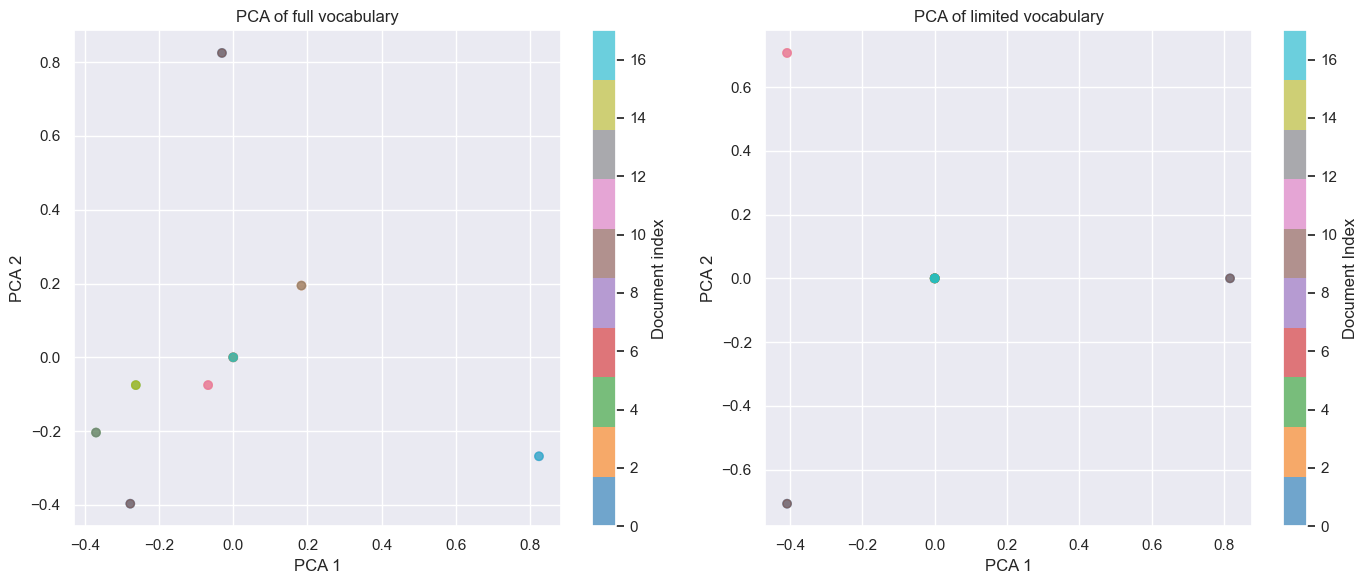

In [83]:
vectorizer_full = CountVectorizer()
xs_full = vectorizer_full.fit_transform(test_text)

pca_full = PCA(n_components=2)
xs_reduced_full = pca_full.fit_transform(xs_full.toarray())

vocabulary = ["myth", "wood", "robot"]
vectorizer_limited = CountVectorizer(vocabulary=vocabulary)
xs_limited = vectorizer_limited.fit_transform(test_text)

pca_limited = PCA(n_components=2)
xs_reduced_limited = pca_limited.fit_transform(xs_limited.toarray())

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
scatter_full = plt.scatter(xs_reduced_full[:, 0], xs_reduced_full[:, 1], c=np.arange(len(xs_reduced_full)), cmap='tab10', alpha=0.6)
plt.colorbar(scatter_full, label='Document index')
plt.title('PCA of full vocabulary')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.subplot(1, 2, 2)
scatter_limited = plt.scatter(xs_reduced_limited[:, 0], xs_reduced_limited[:, 1], c=np.arange(len(xs_reduced_limited)), cmap='tab10', alpha=0.6)
plt.colorbar(scatter_limited, label='Document Index')
plt.title('PCA of limited vocabulary')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.tight_layout()
plt.show()

-----------

### The corpus as individual documents

In [36]:
data = []

for i, corpus in enumerate(tqdm(CORPORA)):
    print(corpus)
    for fp in (TEXT_P / corpus).glob("*.txt"):
        with fp.open() as f:
            text = f.read()
        data.append(
            {
                "id": fp.stem,
                "text": text,
                "category": corpus,
                "cat_id": i,
            }
        )

  0%|          | 0/6 [00:00<?, ?it/s]

mythology
woodworking
robotics
hsm
health
portuguese


In [37]:
doc_df = pd.DataFrame.from_records(data).set_index("id")
doc_df

,text,category,cat_id
id,,,
mythology.stackexchange_0000000511,Q:\n\nWhy were the Greek Gods on Olympus?\n\nI...,mythology,0
mythology.stackexchange_0000004862,Q:\n\nDoes Scotland have any discrete mytholog...,mythology,0
mythology.stackexchange_0000003400,Q:\n\nWhat is the earliest story of summoning ...,mythology,0
mythology.stackexchange_0000001484,Q:\n\nHow did Helen get back from Troy?\n\nThe...,mythology,0
mythology.stackexchange_0000005938,Q:\n\nWhat source makes the claim that Melanip...,mythology,0
...,...,...,...
portuguese.stackexchange_0000000168,Q:\n\nConserto ou Concerto?\n\nÉ visto constan...,portuguese,5
portuguese.stackexchange_0000009583,Q:\n\nUso do ponto e vírgula no lugar de dois-...,portuguese,5
portuguese.stackexchange_0000006412,"Q:\n\nQual é a diferença no uso de ""reparar"" e...",portuguese,5


#### 🚧 TODO: Plot (bar) the number of documents per category

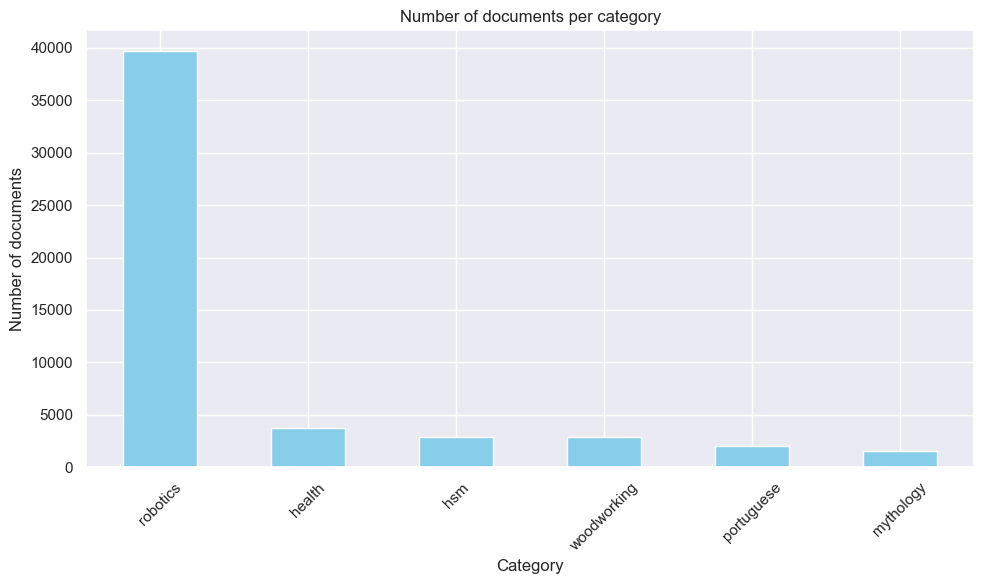

In [38]:
category_counts = doc_df['category'].value_counts()

category_counts.plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Number of documents per category')
plt.xlabel('Category')
plt.ylabel('Number of documents')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### 🚧 TODO: Boxplot the number of tokens per document

* With and without outliers

* Shortly explain the different values presented in a boxplot ([Wikipedia](https://en.wikipedia.org/wiki/Box_plot))

* Are the texts of signifcantly different length? Argue shortly.

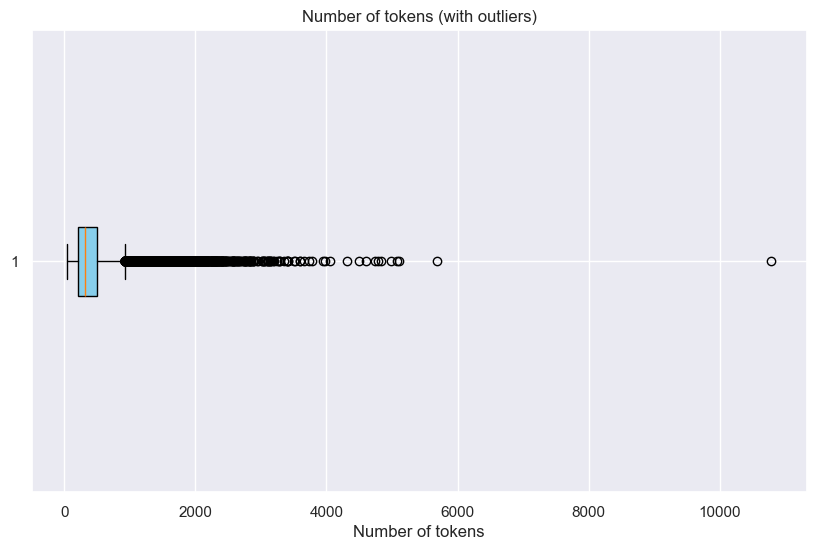

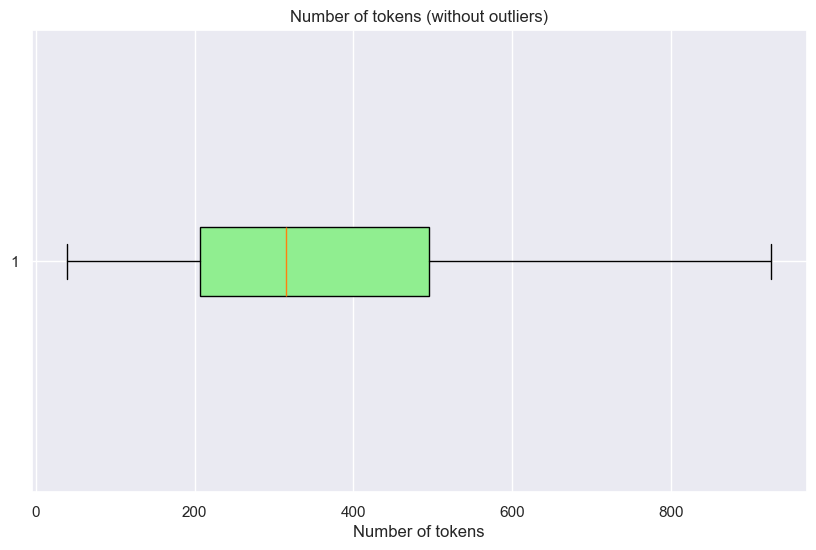

               count    mean     std   min    25%    50%    75%      max
category                                                                
health        3733.0  438.38  330.82  50.0  228.0  349.0  538.0   3596.0
hsm           2887.0  527.79  447.26  45.0  255.0  419.0  694.0  10791.0
mythology     1503.0  562.85  522.98  51.0  255.0  416.0  680.0   5103.0
portuguese    2026.0  393.40  318.36  39.0  184.0  304.0  506.0   3348.0
robotics     39674.0  382.99  299.64  42.0  199.0  298.0  461.0   4610.0
woodworking   2860.0  497.59  313.20  47.0  273.0  422.5  641.0   2846.0


In [39]:
doc_df["tokens"] = doc_df["text"].str.split()
doc_df["tokens_n"] = doc_df["tokens"].map(len)

plt.figure(figsize=(10, 6))
plt.boxplot(doc_df["tokens_n"], vert=False, patch_artist=True, boxprops=dict(facecolor='skyblue'))
plt.title('Number of tokens (with outliers)')
plt.xlabel('Number of tokens')
plt.show()

# without outliers
plt.figure(figsize=(10, 6))
plt.boxplot(doc_df["tokens_n"], vert=False, patch_artist=True, showfliers=False, boxprops=dict(facecolor='lightgreen'))
plt.title('Number of tokens (without outliers)')
plt.xlabel('Number of tokens')
plt.show()

# check if text lengths are significantly different by examining basic statistics
summary_stats = doc_df.groupby("category")["tokens_n"].describe()
print(summary_stats)

Yes, the texts are different in length across categories.

The differences in mean token counts, standard deviations and quartiles show that categories like mythology and hsm have longer and more variable texts, while robotics and portuguese are shorter.

#### 🚧 TODO: How to find the crazy long robotics text?

*   Find the index of the longest text

*   Show the content

*   Explain why this text is so long (what does it contain?)

In [40]:
robotics_df = doc_df[doc_df["category"] == "robotics"]

longest_index = robotics_df["tokens_n"].idxmax()

longest_text = doc_df.loc[longest_index, "text"]

print(f"Index of the longest text: {longest_index}")
print(f"Number of tokens: {robotics_df.loc[longest_index, 'tokens_n']}")
print("Content of the longest text:")
print(longest_text)

Index of the longest text: robotics.stackexchange_0000074620
Number of tokens: 4610
Content of the longest text:
Q:

Localisation inaccurate because navsat_transform is incorrectly calculating odometry

I'm trying to localise my robot in an outdoor environment by integrating GPS data in ROS. I'm running two ekf_localisation instances and one navsat_transform instance. In addition, I'm running an instance of /move_base so I can send ActionGoals to control the UGV. But in general, the localisation is inaccurate, and the origin of my /map and /odom frames move relative to each other, and relative to the real world. I'm not entirely sure why.
In addition, I'm trying to use navsat_transform to create a /map frame at a specified latitude/longitude whose 'Y' axis always faces true north. But I'm having difficulty achieving this as well, and I suspect that one problem is causing or at least contributing to the other.
Here is all the details and diagnostic info:
Robot: Clearpath Jackal UGV
OS: 

### Vectorizing again

#### 🚧 TODO: See how many features we get if we don't restrict their number

* Use again the `CountVectorizer` to vectorize the stackoverflow corpus

  * But use the whole vocabulary of the documents this time (**without** `vocabulary=words`)

  * Tell how many features are obtained

* Then limit the vocabulary to the 5000 most frequent words

* Apply and plot dimensionality reduction to 2 dimensions as prevously
  (only on the limited vocabulary)

We want something like this:

```python
xs ~ doc_df.text
ys ~ doc_df.cat_id
```

In [44]:
ys = doc_df.cat_id.values

In [41]:
unconstrained_cv = CountVectorizer()
unconstrained_xs = unconstrained_cv.fit_transform(doc_df.text)

print(f"Number of features (unconstrained vocabulary): {len(unconstrained_cv.get_feature_names_out())}")

Number of features (unconstrained vocabulary): 396573


In [42]:
cv = CountVectorizer(max_features=5000)
xs_limited = cv.fit_transform(doc_df.text)

print(f"Number of features (limited to 5000 words): {xs_limited.shape[1]}")

Number of features (limited to 5000 words): 5000


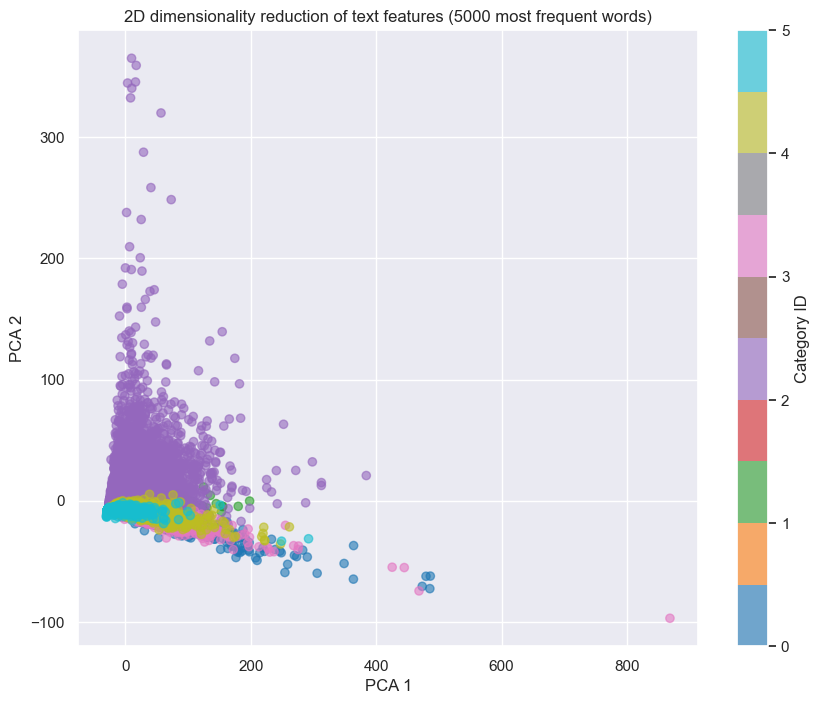

In [46]:
pca = PCA(n_components=2)
xs_reduced = pca.fit_transform(xs_limited.toarray())

plt.figure(figsize=(10, 8))
scatter = plt.scatter(xs_reduced[:, 0], xs_reduced[:, 1], c=ys, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Category ID')
plt.title('2D dimensionality reduction of text features (5000 most frequent words)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

#### 🚧 TODO: Find that outlier!

* Use pandas to find the document corresponding to the outlier

* Print the correspoding text
  
* Tell what it contains (if you could figure it out)

* Remove the corresping raw from the dataframe and redo the dimensional reduction (and plot)

Outlier index: 46375
Distance of outlier from center: 873.8527962658761
Outlier text content:
Q:

Conditionally convergent series

I am looking for the original reference discussing a specific, elementary example of a rearrangement of series converging to a value different from the original series. In what follows, I give some (meager) context and make explicit the example whose origin I am trying to locate.

Apparently, Dirichlet was first to note that a conditionally convergent series may be rearranged so that the resulting series converges to a different value. In 1837, in his paper showing that any arithmetic progression $(a+bn)_{n\ge0}$ contains infinitely many primes provided that $a,b$ are relatively prime, he gives an example and also proves that rearranging an absolutely convergent series has no effect on its limit.
In 1853, Riemann proved his rearrangement theorem, although it was not published until 1866, as part of his Habilitationsschrift on representation of functions as 

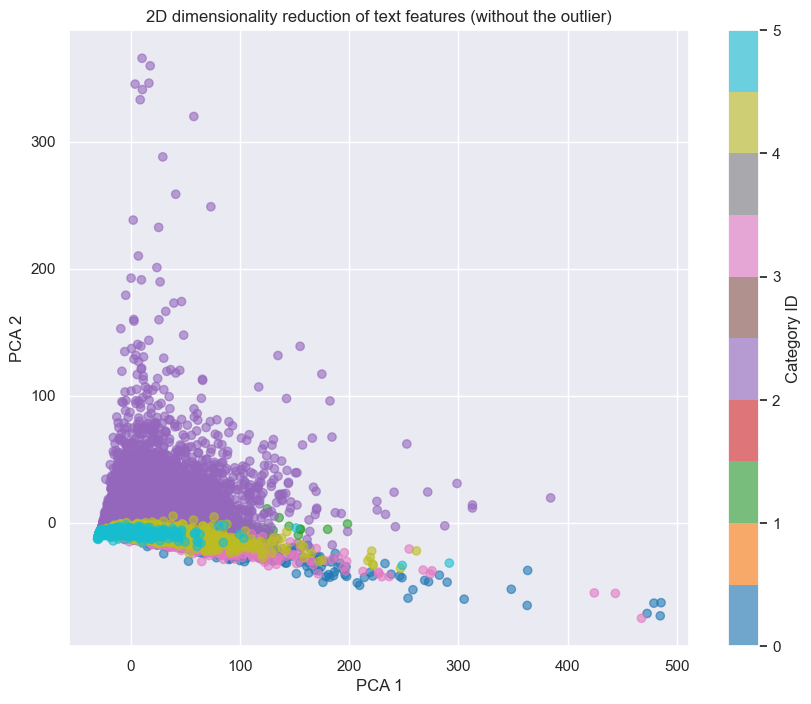

In [58]:
center = xs_reduced.mean(axis=0)
distances = np.linalg.norm(xs_reduced - center, axis=1)

outlier_idx = np.argmax(distances)
print(f"Outlier index: {outlier_idx}")
print(f"Distance of outlier from center: {distances[outlier_idx]}")

outlier_text = doc_df.iloc[outlier_idx]["text"]
print("Outlier text content:")
print(outlier_text)

doc_df_no_outlier = doc_df.iloc[np.arange(len(doc_df)) != outlier_idx].reset_index(drop=True)

cv = CountVectorizer(max_features=5000)
xs_limited_no_outlier = cv.fit_transform(doc_df_no_outlier.text)

pca = PCA(n_components=2)
xs_reduced_no_outlier = pca.fit_transform(xs_limited_no_outlier.toarray())

plt.figure(figsize=(10, 8))
scatter = plt.scatter(xs_reduced_no_outlier[:, 0], xs_reduced_no_outlier[:, 1], c=doc_df_no_outlier.cat_id.values, cmap='tab10', alpha=0.6)
plt.colorbar(scatter, label='Category ID')
plt.title('2D dimensionality reduction of text features (without the outlier)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

The outlier seems to be an extremely detailed question and answer related to some historical mathematical concepts. It seems to include a lot of citations.

#### 🚧 TODO: The reason for this outlier is...

*   Give a short explanation

*   Remove the outlier from the dataframe

*   Redo the dimensional reduction

*   Plot the 2D vectors and color them by category

Already done in the previous cell.

### Split the data in training and test sets

In [68]:
ys = doc_df.cat_id.values

ys = doc_df_no_outlier.cat_id.values
xs = cv.transform(doc_df_no_outlier.text)

train_xs, test_xs, train_ys, test_ys = model_selection.train_test_split(
    xs, ys, test_size=0.3, random_state=0, shuffle=True
)
print(train_xs.shape)
print(test_xs.shape)

(36877, 5000)
(15805, 5000)


### 🚧 TODO: Apply different algorithms to try predicting the category

* E.g., Logistic Regression, Multinomial Naive Bayes, Decision Tree Classifier, Random Forest, Support Vector Classifer.

* You could investigate [`SGDClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html), which implements linear classifiers (e.g, SVM, logistic regression) with SGD training (faster).

* Present a table with the results of the different algorithms (e.g., accuracy, precision, recall, f1-score) and their execution time

* (Optional) Analyse 1 algorythm in detail (e.g., Logistic Regression)

  *   Try different parameters (possibly with a grid search)

  *   Present the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)

  *   Present the confusion matrix of the best model

In [76]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn import preprocessing
import time

In [73]:
def evaluate_model(model, train_xs, test_xs, train_ys, test_ys):
    start_time = time.time()
    model.fit(train_xs, train_ys)
    predictions = model.predict(test_xs)
    end_time = time.time()
    
    accuracy = accuracy_score(test_ys, predictions)
    precision = precision_score(test_ys, predictions, average="weighted", zero_division=0)
    recall = recall_score(test_ys, predictions, average="weighted", zero_division=0)
    f1 = f1_score(test_ys, predictions, average="weighted", zero_division=0)
    exec_time = end_time - start_time
    
    return accuracy, precision, recall, f1, exec_time

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=0),
    "Multinomial NB": MultinomialNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Random Forest": RandomForestClassifier(random_state=0),
    "Support Vector Classifier": SVC(random_state=0),
    "SGD Classifier": SGDClassifier(random_state=0),
}

results = []
for model_name, model in models.items():
    accuracy, precision, recall, f1, exec_time = evaluate_model(
        model, train_xs, test_xs, train_ys, test_ys
    )

    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Execution Time (s)": exec_time,
    })

results_df = pd.DataFrame(results)
print(results_df)

                       Model  Accuracy  Precision  Recall  F1 Score  \
0        Logistic Regression      0.99       0.99    0.99      0.99   
1             Multinomial NB      0.97       0.97    0.97      0.97   
2              Decision Tree      0.96       0.96    0.96      0.96   
3              Random Forest      0.99       0.99    0.99      0.99   
4  Support Vector Classifier      0.98       0.98    0.98      0.98   
5             SGD Classifier      0.99       0.99    0.99      0.99   

   Execution Time (s)  
0               35.48  
1                0.07  
2                7.82  
3               53.23  
4              809.98  
5                2.36  


Best parameters: {'alpha': 0.0001}
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       433
           1       0.90      1.00      0.95       879
           2       1.00      0.98      0.99     11887
           3       0.86      0.96      0.91       853
           4       0.96      0.98      0.97      1117
           5       1.00      0.92      0.96       636

    accuracy                           0.98     15805
   macro avg       0.94      0.97      0.95     15805
weighted avg       0.98      0.98      0.98     15805



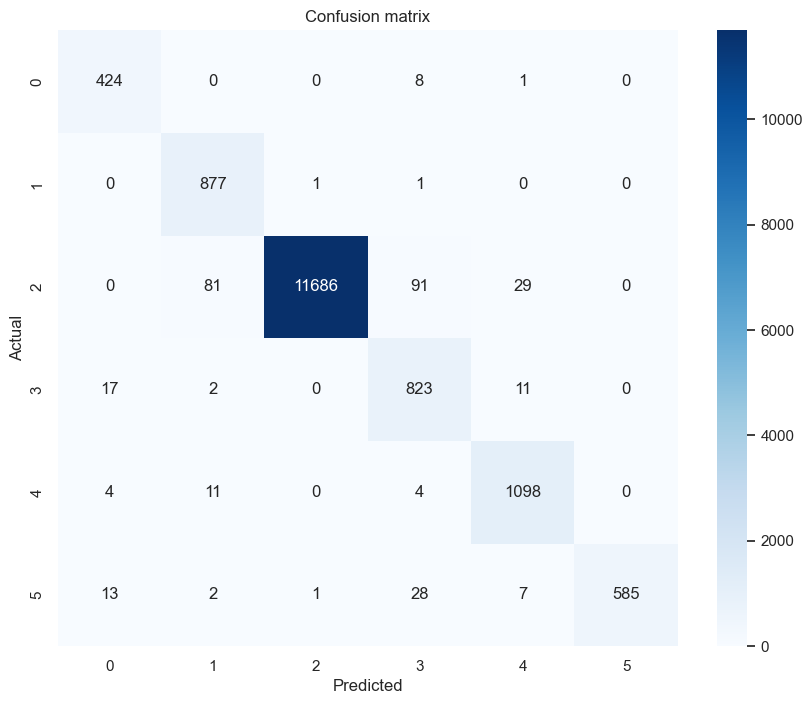

In [85]:
param_grid = {
    "alpha": [0.0001, 0.001, 0.01, 0.1],
}

grid_search = GridSearchCV(
    MultinomialNB(),
    param_grid, 
    cv=3, 
    scoring="f1_weighted"
)

grid_search.fit(train_xs, train_ys)

best_nb = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

predictions = best_nb.predict(test_xs)
print(classification_report(test_ys, predictions))

conf_matrix = confusion_matrix(test_ys, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_ys), yticklabels=np.unique(test_ys))
plt.title("Confusion matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 🚧 TODO: Explain what model seems to work best

Logistic Regression, Random Forest and SGD Classifier all perform excellently with an accuracy, precision, recall, and F1 score of 0.99. However, SGD Classifier is slightly faster than Logistic Regression and Random Forest, making it a good choice for high-performance scenarios.

Multinomial Naive Bayes has the fastest execution time (0.07 seconds), though it has slightly lower metrics compared to the top-performing models.

Logistic Regression seems to be the best overall, offering excellent performance with a reasonable execution time.

____